# Martingale-Aware Alpha

The goal of this notebook is to show how (i) to separate “signal” from “noise” using a martingale baseline, and (ii) mean-reversion (OU / AR(1)) turns into a concrete trading hypothesis.

There are three repeated steps in every example:

1. **Build a residual** $\varepsilon_t$: something that “should” be near a fair value once the obvious pricing logic / hedges are applied.
2. **Test the martingale baseline**: check whether the residual change looks like a *martingale difference*, i.e.
   $\mathbb E[\varepsilon_{t+h}-\varepsilon_t\mid\mathcal F_t] \approx 0$.  
   We test several horizons $h$ because mean reversion can take weeks or months.
3. **Try a mean-reversion strategy** and report a cost-aware PnL proxy.  
   This is intentionally simple; it is only meant to connect the math to a backtest-shaped object.

Important practical note: in real markets, “alpha” can vanish because of microstructure, costs, borrow/funding frictions, regime changes, or because the residual was not truly hedged. The notebook includes a control case where the residual is pure noise and the strategy should not work.

## 0. Imports and basic utilities

In [4]:
import math

import numpy as np 
np.random.seed(7)

import pandas as pd
pd.set_option("display.float_format", "{:,.4f}".format)

import matplotlib.pyplot as plt
def set_mpl_defaults():
    # Use matplotlib defaults; do not set explicit colors.
    plt.rcParams.update({
        "figure.figsize": (15, 3),
        "axes.grid": False,
        "grid.alpha": 0.3,
        "axes.titlesize": 12,
        "axes.labelsize": 11,
        "legend.frameon": False,
    })
set_mpl_defaults()

## 1. Core building blocks

### 1.1 OU in continuous time and AR(1) in discrete time

Continuous-time OU (under \(P\)):
\begin{align}
d\varepsilon_t &= \kappa(\mu - \varepsilon_t)\,dt + \sigma\,dW_t,\qquad \kappa>0.
\end{align}

A simple discrete-time approximation is AR(1):
\begin{align}
\varepsilon_{t+1}-\mu &= \rho(\varepsilon_t-\mu) + \eta_{t+1},\qquad |\rho|<1,\ \mathbb{E}[\eta_{t+1}\mid\mathcal{F}_t]=0.
\end{align}

Connection (unit time step): $\kappa \approx 1-\rho$.  
Half-life intuition:
\begin{align}
h_{1/2} \approx \frac{\ln 2}{\kappa}\quad\text{(continuous time)} \qquad \text{or}\qquad h_{1/2} \approx \frac{\ln 2}{-\ln\rho}\quad\text{(discrete)}.
\end{align}

### 1.2 “Martingale-difference” diagnostic for a residual

A standard test of predictability is a regression of horizon-$h$ changes on today’s residual:
\begin{align}
\varepsilon_{t+h}-\varepsilon_t &= a_h + b_h(\varepsilon_t-\bar\varepsilon) + \text{noise}.
\end{align}

- If $b_h\approx 0$: martingale-difference-like behavior at horizon $h$ (no systematic mean reversion).
- If $b_h<0$: mean reversion (larger residual today predicts negative future change).


In [2]:
def simulate_ou_discrete(n, mu=0.0, kappa=0.02, sigma=1.0, dt=1.0, x0=None):
    """Euler discretization of OU:
      x_{t+1} = x_t + kappa*(mu - x_t)*dt + sigma*sqrt(dt)*z
    """
    if x0 is None:
        x0 = mu
    x = np.empty(n)
    x[0] = x0
    for t in range(n-1):
        z = np.random.normal()
        x[t+1] = x[t] + kappa*(mu - x[t])*dt + sigma*math.sqrt(dt)*z
    return x

def ols_with_se(X, y):
    """OLS with (homoskedastic) standard errors."""
    X = np.asarray(X)
    y = np.asarray(y)
    n, k = X.shape
    beta = np.linalg.lstsq(X, y, rcond=None)[0]
    resid = y - X @ beta
    s2 = (resid @ resid) / (n - k)
    XtX_inv = np.linalg.inv(X.T @ X)
    se = np.sqrt(np.diag(s2 * XtX_inv))
    tstat = beta / se
    return beta, se, tstat, resid

def mean_reversion_test(eps, horizons=(1,5,20,60)):
    """For each horizon h, regress (eps_{t+h}-eps_t) on [1, eps_t-mean(eps)]."""
    eps = np.asarray(eps)
    eps_center = eps - np.mean(eps)
    out = []
    for h in horizons:
        if h >= len(eps)-1:
            continue
        y = eps[h:] - eps[:-h]
        x = eps_center[:-h]
        X = np.column_stack([np.ones_like(x), x])
        beta, se, tstat, _ = ols_with_se(X, y)
        out.append({"h": h, "a_hat": beta[0], "b_hat": beta[1], "t(b_hat)": tstat[1]})
    return pd.DataFrame(out)

def fit_ar1(eps):
    """Fit eps_{t+1} = c + rho*eps_t + err and report implied (mu, kappa)."""
    eps = np.asarray(eps)
    y = eps[1:]
    x = eps[:-1]
    X = np.column_stack([np.ones_like(x), x])
    beta, se, tstat, resid = ols_with_se(X, y)
    c_hat, rho_hat = beta
    if abs(1 - rho_hat) < 1e-6:
        mu_hat = np.mean(eps)
    else:
        mu_hat = c_hat / (1 - rho_hat)
    kappa_hat = 1 - rho_hat
    sigma_hat = np.std(resid, ddof=2)
    if rho_hat <= 0:
        half_life = np.nan
    else:
        half_life = math.log(2) / (-math.log(rho_hat))
    return {
        "c_hat": c_hat,
        "rho_hat": rho_hat,
        "mu_hat": mu_hat,
        "kappa_hat": kappa_hat,
        "sigma_hat": sigma_hat,
        "half_life_steps": half_life,
        "t(rho_hat)": tstat[1]
    }

def backtest_zscore_mean_reversion(eps, lookback=60, entry=2.0, exit=0.5, cost_per_turnover=0.0005):
    """Simple z-score mean-reversion backtest on a residual."""
    eps = pd.Series(eps).reset_index(drop=True)
    roll_mean = eps.rolling(lookback).mean()
    roll_std = eps.rolling(lookback).std(ddof=0)
    z = (eps - roll_mean) / roll_std

    pos = pd.Series(0.0, index=eps.index)
    in_trade = False
    current_pos = 0.0

    for t in range(len(eps)):
        if np.isnan(z.iloc[t]):
            pos.iloc[t] = 0.0
            continue

        if not in_trade:
            if abs(z.iloc[t]) > entry:
                current_pos = -np.sign(z.iloc[t])  # mean reversion
                in_trade = True
        else:
            if abs(z.iloc[t]) < exit:
                current_pos = 0.0
                in_trade = False

        pos.iloc[t] = current_pos

    de = eps.diff().shift(-1)           # forward change: eps_{t+1}-eps_t aligned at t
    pnl_gross = pos * de             # profit proxy: position times next-step change in residual
    turnover = pos.diff().abs().fillna(0.0)
    costs = cost_per_turnover * turnover
    pnl_net = (pnl_gross - costs).fillna(0.0)

    df = pd.DataFrame({
        "eps": eps,
        "z": z,
        "pos": pos,
        "pnl_gross": pnl_gross,
        "costs": costs,
        "pnl_net": pnl_net,
        "cum_pnl": pnl_net.cumsum()
    })
    return df

def summarize_residual(eps, name="residual", horizons=(1,5,20,60)):
    eps = np.asarray(eps)
    ar1 = fit_ar1(eps)
    tests = mean_reversion_test(eps, horizons=horizons)

    print(f"=== {name} ===")
    print("AR(1) fit: eps_{t+1} = c + rho*eps_t + err")
    for k in ["mu_hat", "rho_hat", "kappa_hat", "sigma_hat", "half_life_steps", "t(rho_hat)"]:
        print(f"  {k:>14s}: {ar1[k]: .4f}")

    print("\nMean-reversion test: (eps_{t+h}-eps_t) ~ a + b*(eps_t-mean)")
    display(tests)

    plt.figure()
    plt.plot(eps)
    plt.title(f"{name}: residual time series")
    plt.xlabel("t")
    plt.ylabel("level")
    plt.show()

    return ar1, tests


## 2. Pricing baseline: discounted prices are martingales under \(Q\) 

We simulate GBM under two measures:

\begin{align}
dS_t &= \mu S_t\,dt + \sigma S_t\,dW_t^P \quad\text{(under \(P\))}\\
dS_t &= r S_t\,dt + \sigma S_t\,dW_t^Q \quad\text{(under \(Q\))}\\
\tilde S_t &= e^{-rt}S_t.
\end{align}

Under $Q$, $\mathbb{E}^Q[\tilde S_t]$ is flat (martingale benchmark in expectation). Under $P$, it generally is not.


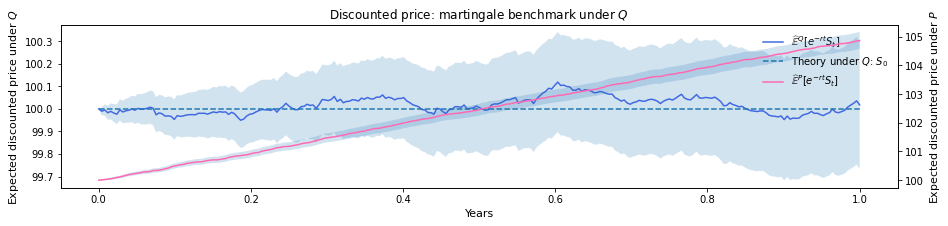

In [5]:
def simulate_gbm(n_steps=252, n_paths=20000, s0=100.0, mu=0.08, r=0.03, sigma=0.2, dt=1/252, measure="P"):
    drift = r if measure.upper() == "Q" else mu
    S = np.empty((n_paths, n_steps+1))
    S[:, 0] = s0
    for t in range(n_steps):
        z = np.random.normal(size=n_paths)
        S[:, t+1] = S[:, t] * np.exp((drift - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*z)
    return S

def plot_discounted_expectation():
    n_steps = 252
    dt = 1/252
    times = np.arange(n_steps + 1) * dt
    r = 0.03
    n_paths = 20000

    S_Q = simulate_gbm(n_steps=n_steps, n_paths=n_paths, mu=0.08, r=r, sigma=0.2, dt=dt, measure="Q")
    S_P = simulate_gbm(n_steps=n_steps, n_paths=n_paths, mu=0.08, r=r, sigma=0.2, dt=dt, measure="P")

    disc = np.exp(-r * times)
    discS_Q = S_Q * disc
    discS_P = S_P * disc

    Ed_Q = discS_Q.mean(axis=0)
    Ed_P = discS_P.mean(axis=0)

    # Monte Carlo standard errors
    se_Q = discS_Q.std(axis=0, ddof=1) / np.sqrt(n_paths)
    se_P = discS_P.std(axis=0, ddof=1) / np.sqrt(n_paths)

    # Theoretical mean under Q: E^Q[e^{-rt}S_t] = S0
    S0 = discS_Q[0, 0]
    theo = np.full_like(times, S0, dtype=float)

    fig, ax1 = plt.subplots()

    line1, = ax1.plot(times, Ed_Q, label=r"$\widehat{\mathbb{E}}^Q[e^{-rt}S_t]$", c='royalblue')
    ax1.plot(times, theo, linestyle="--", label=r"Theory under $Q$: $S_0$")
    ax1.fill_between(times, Ed_Q - 2*se_Q, Ed_Q + 2*se_Q, alpha=0.2)

    ax1.set_xlabel("Years")
    ax1.set_ylabel(r"Expected discounted price under $Q$")

    ax2 = ax1.twinx()
    line2, = ax2.plot(times, Ed_P, label=r"$\widehat{\mathbb{E}}^P[e^{-rt}S_t]$", c='hotpink')
    ax2.fill_between(times, Ed_P - 2*se_P, Ed_P + 2*se_P, alpha=0.2)
    ax2.set_ylabel(r"Expected discounted price under $P$")

    ax1.set_title("Discounted price: martingale benchmark under $Q$")

    # One legend (combine handles from both axes)
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="best", frameon=False)

    plt.show()

plot_discounted_expectation()

## 3. Martingale-aware alpha 

Think of the martingale concept as a **filter**:

- If your residual behaves like “fair coin flips” after conditioning on what you know today, then **there is no repeatable edge (alpha)** in that residual.
- If your residual has a **predictable drift** (often mean reversion), then you have a **candidate (alpha)** source — subject to costs, sizing, and robustness.

Operationally we do two diagnostics:

**(A) AR(1) / OU fit (mean reversion speed).**  
We fit a simple AR(1) model $\varepsilon_{t+1}-\mu = \rho(\varepsilon_t-\mu)+\eta_{t+1}$.  
From $\rho$ we back out $\kappa = 1-\rho$ and a rough **half-life**. This tells you the time scale on which reversion shows up.

**(B) “Martingale-difference” predictability test at multiple horizons.**  
For each horizon \(h\), we regress the *future change* $\varepsilon_{t+h}-\varepsilon_t$ on today’s level $\varepsilon_t-\mu$.
Mean reversion predicts a negative slope: when $\varepsilon_t$ is high, future changes should be negative.

The main output to read is the slope $b_h$ and its t-stat: big negative $b_h$ at some horizons is a sign of mean reversion;
near-zero slopes across horizons look like a martingale difference.

## 4. Test using different asset classes

Now we are ready to perform some strategies using different asset classes.

## Example 1 — Put–Call parity residual (synthetic)

**What we are modeling.** Put–call parity implies a tight relationship between call/put prices and the forward value of the underlying.
In the real world, quotes can deviate because of bid/ask, discrete dividends, borrow costs, and funding spreads.
We compress all of that into one residual \(\varepsilon^{par}_t\).

**What to look for in the output.**
- The AR(1) fit should show \(|\rho|<1\) and a reasonable half-life.
- The predictability test should show **negative** slopes \(b_h\) (mean reversion) at the horizons where reversion actually happens.
- The backtest should show that *gross* PnL has the correct sign, and then you can see how costs reduce it.


=== Put–Call Parity Residual ===
AR(1) fit: eps_{t+1} = c + rho*eps_t + err
          mu_hat: -0.3923
         rho_hat:  0.9658
       kappa_hat:  0.0342
       sigma_hat:  0.5454
  half_life_steps:  19.8928
      t(rho_hat):  116.5107

Mean-reversion test: (eps_{t+h}-eps_t) ~ a + b*(eps_t-mean)


,h,a_hat,b_hat,t(b_hat)
0,1,0.0018,-0.0342,-4.1313
1,5,0.0047,-0.1541,-9.0213
2,20,-0.0132,-0.3748,-14.9295
3,60,-0.1125,-0.6753,-21.9383
4,120,-0.3811,-1.0845,-34.7304


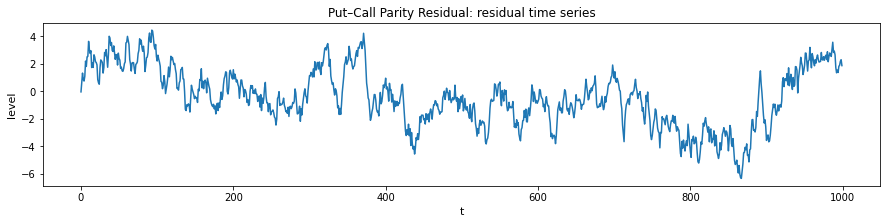

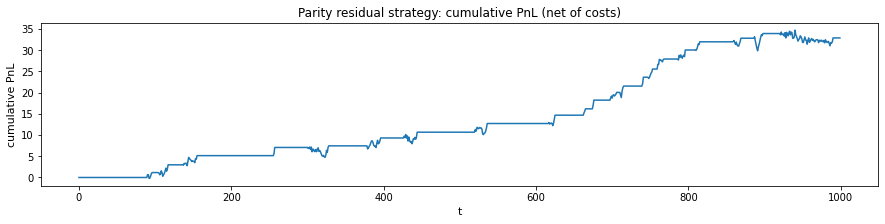

Summary:
             count   mean    std     min    25%    50%    75%    max
pnl_net 1,000.0000 0.0329 0.3099 -1.3480 0.0000 0.0000 0.0000 1.6515


In [6]:
n = 1000  # ~4 years of daily observations

mu_true_par = 0.0
kappa_true_par = 0.03   # half-life ~ ln2/0.03 ≈ 23 steps (roughly a month)
sigma_true_par = 0.5

eps_par = simulate_ou_discrete(n, mu=mu_true_par, kappa=kappa_true_par, sigma=sigma_true_par, dt=1.0, x0=0.0)
eps_par_obs = eps_par + np.random.normal(scale=0.15, size=n)  # microstructure noise

ar1_par, tests_par = summarize_residual(eps_par_obs, name="Put–Call Parity Residual", horizons=(1,5,20,60,120))

bt_par = backtest_zscore_mean_reversion(eps_par_obs, lookback=80, entry=2.0, exit=0.6, cost_per_turnover=0.002)

plt.figure()
plt.plot(bt_par["cum_pnl"])
plt.title("Parity residual strategy: cumulative PnL (net of costs)")
plt.xlabel("t")
plt.ylabel("cumulative PnL")
plt.show()

print("Summary:")
print(bt_par[["pnl_net"]].describe().T)


## Example 2 — Futures–Spot basis residual (synthetic)

**What we are modeling.** The cost-of-carry model gives a “fair” futures price from spot and carry inputs.
Any deviation is a **basis residual** $\varepsilon^{bas}_t$. In practice, persistent funding / balance-sheet effects
can make the residual mean-revert to a nonzero $\mu$.

**What to look for.**
Same as Example 1: AR(1) half-life (time scale), predictability slopes across horizons, and how costs affect a strategy.


=== Futures–Spot Basis Residual ===
AR(1) fit: eps_{t+1} = c + rho*eps_t + err
          mu_hat: -0.4716
         rho_hat:  0.9867
       kappa_hat:  0.0133
       sigma_hat:  0.8098
  half_life_steps:  51.8957
      t(rho_hat):  182.2134

Mean-reversion test: (eps_{t+h}-eps_t) ~ a + b*(eps_t-mean)


,h,a_hat,b_hat,t(b_hat)
0,1,0.0059,-0.0133,-2.4501
1,5,0.0278,-0.0649,-5.4996
2,20,0.1408,-0.2514,-10.9093
3,60,0.3861,-0.6406,-18.7753
4,120,0.3798,-0.9758,-21.8299
5,250,-0.0006,-1.2910,-27.0588


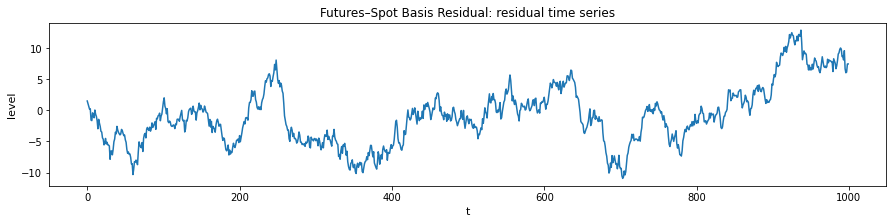

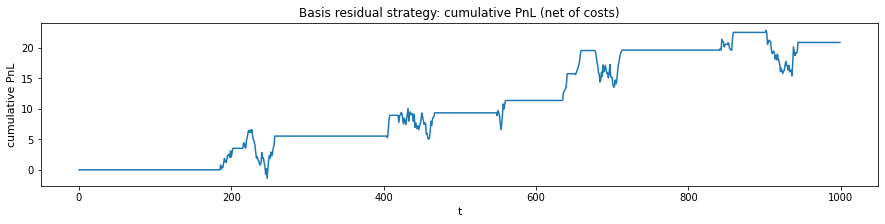

Summary:
             count   mean    std     min    25%     50%    75%    max
pnl_net 1,000.0000 0.0209 0.4086 -2.1663 0.0000 -0.0000 0.0000 2.8054


In [7]:
n = 1000
dt = 1/252

# Spot (P-measure) GBM
muP, sigmaS = 0.06, 0.18
S = np.empty(n)
S[0] = 100.0
for t in range(n-1):
    z = np.random.normal()
    S[t+1] = S[t] * np.exp((muP - 0.5*sigmaS**2)*dt + sigmaS*np.sqrt(dt)*z)

# Fair futures from carry (simplified)
r = 0.03
q = 0.01
T_years = 0.25  # 3 months
carry = (r - q)
F_fair = S * np.exp(carry * T_years)

# Basis residual (OU-like) with nonzero mean
mu_true_bas = 1.5
kappa_true_bas = 0.01     # slower mean reversion
sigma_true_bas = 0.8

eps_bas = simulate_ou_discrete(n, mu=mu_true_bas, kappa=kappa_true_bas, sigma=sigma_true_bas, dt=1.0, x0=mu_true_bas)
F_mkt = F_fair + eps_bas
eps_bas_obs = F_mkt - F_fair

ar1_bas, tests_bas = summarize_residual(eps_bas_obs, name="Futures–Spot Basis Residual", horizons=(1,5,20,60,120,250))

bt_bas = backtest_zscore_mean_reversion(eps_bas_obs, lookback=120, entry=2.2, exit=0.7, cost_per_turnover=0.0015)

plt.figure()
plt.plot(bt_bas["cum_pnl"])
plt.title("Basis residual strategy: cumulative PnL (net of costs)")
plt.xlabel("t")
plt.ylabel("cumulative PnL")
plt.show()

print("Summary:")
print(bt_bas[["pnl_net"]].describe().T)


## 6) Example 3 — Rates fly (butterfly) residual (synthetic)

**What we are modeling.** A rates “fly” isolates curve curvature: the belly maturity relative to the wings.
We define a fly, define a “fair” level, and trade the residual \(\varepsilon^{fly}_t\).

**What to look for.**
If the residual is truly mean reverting, the slopes \(b_h\) should be negative at the right horizons.
If costs are high relative to the size of residual moves, the backtest can still fail even if the statistics look good.


=== Rates Fly Residual ===
AR(1) fit: eps_{t+1} = c + rho*eps_t + err
          mu_hat: -0.1368
         rho_hat:  0.9849
       kappa_hat:  0.0151
       sigma_hat:  0.2497
  half_life_steps:  45.5356
      t(rho_hat):  179.2693

Mean-reversion test: (eps_{t+h}-eps_t) ~ a + b*(eps_t-mean)


,h,a_hat,b_hat,t(b_hat)
0,1,0.0003,-0.0151,-2.7497
1,5,-0.0007,-0.0682,-5.9285
2,20,-0.0095,-0.2735,-12.4857
3,60,-0.0352,-0.5226,-18.1283
4,120,-0.1858,-0.5962,-18.5298
5,250,-0.3683,-0.6309,-11.3716


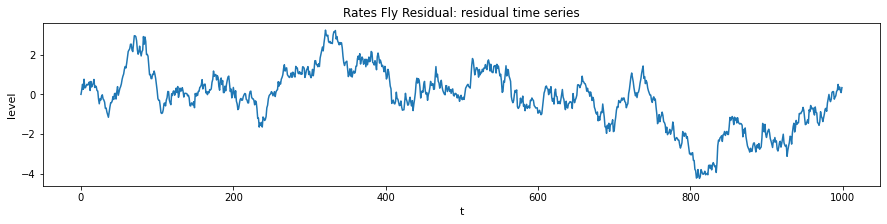

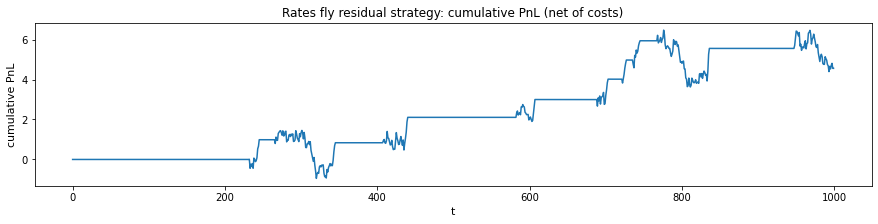

Summary:
             count   mean    std     min     25%    50%    75%    max
pnl_net 1,000.0000 0.0046 0.1326 -0.6783 -0.0000 0.0000 0.0000 0.8521


In [8]:
n = 1000

# Simulate an OU-like fly residual directly (pedagogical)
mu_true_fly = 0.0
kappa_true_fly = 0.015
sigma_true_fly = 0.25
eps_fly = simulate_ou_discrete(n, mu=mu_true_fly, kappa=kappa_true_fly, sigma=sigma_true_fly, dt=1.0, x0=0.0)

ar1_fly, tests_fly = summarize_residual(eps_fly, name="Rates Fly Residual", horizons=(1,5,20,60,120,250))

bt_fly = backtest_zscore_mean_reversion(eps_fly, lookback=150, entry=2.0, exit=0.6, cost_per_turnover=0.001)

plt.figure()
plt.plot(bt_fly["cum_pnl"])
plt.title("Rates fly residual strategy: cumulative PnL (net of costs)")
plt.xlabel("t")
plt.ylabel("cumulative PnL")
plt.show()

print("Summary:")
print(bt_fly[["pnl_net"]].describe().T)


## 7) Example 4 — Stat-arb cointegration spread (synthetic)

**What we are modeling.** We generate two price series whose logs are cointegrated by construction.
The spread \(Z_t = \log X_t - \beta\log Y_t\) is designed to be stationary / mean reverting.

**What to look for.**
- We estimate \(\beta\) by OLS and form the estimated spread \(\hat Z_t\).
- Then we run the same AR(1) and predictability tests on \(\hat Z_t\).
This example highlights a real issue: estimating \(\beta\) adds noise, and that can dilute the measured alpha.


Estimated beta: 4.8767 (true 1.2000), t-stat 6.67
=== Stat-arb Spread (estimated) ===
AR(1) fit: eps_{t+1} = c + rho*eps_t + err
          mu_hat: -0.4280
         rho_hat:  0.9903
       kappa_hat:  0.0097
       sigma_hat:  0.3458
  half_life_steps:  71.3521
      t(rho_hat):  237.4679

Mean-reversion test: (eps_{t+h}-eps_t) ~ a + b*(eps_t-mean)


,h,a_hat,b_hat,t(b_hat)
0,1,-0.0041,-0.0097,-2.3181
1,5,-0.0198,-0.0453,-5.0512
2,20,-0.0418,-0.1525,-9.6337
3,60,-0.1011,-0.4060,-16.6217
4,120,-0.1946,-0.7828,-24.2787
5,250,-0.2637,-1.2312,-28.5067


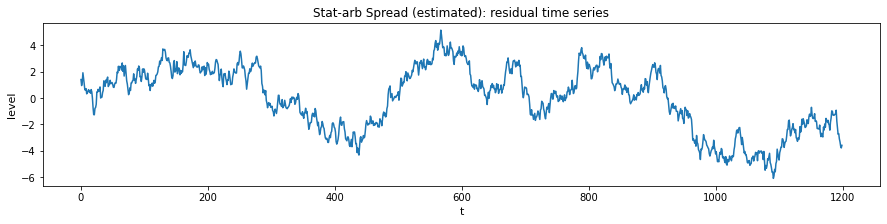

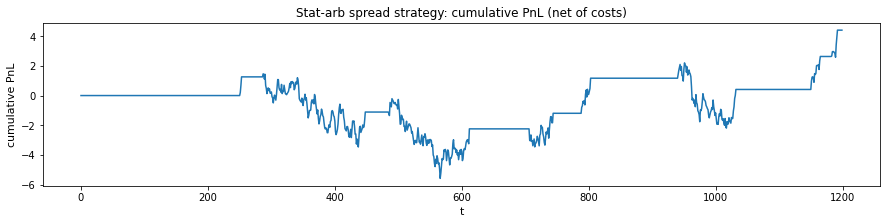

Summary:
             count   mean    std     min    25%    50%    75%    max
pnl_net 1,200.0000 0.0037 0.2141 -0.8846 0.0000 0.0000 0.0000 1.0048


In [9]:
n = 1200
beta_true = 1.2

# log Y random walk
logY = np.zeros(n)
for t in range(n-1):
    logY[t+1] = logY[t] + 0.01*np.random.normal()

# Z mean-reverting
mu_true_Z = 0.0
kappa_true_Z = 0.01
sigma_true_Z = 0.35
Z = simulate_ou_discrete(n, mu=mu_true_Z, kappa=kappa_true_Z, sigma=sigma_true_Z, dt=1.0, x0=0.0)

logX = beta_true*logY + Z
X = np.exp(logX)
Y = np.exp(logY)

# Estimate beta: logX ~ a + beta*logY
Xreg = np.column_stack([np.ones(n), logY])
beta_hat, se, tstat, resid = ols_with_se(Xreg, logX)
a_hat, beta_hat = beta_hat
print(f"Estimated beta: {beta_hat:.4f} (true {beta_true:.4f}), t-stat {tstat[1]:.2f}")

Z_hat = (logX - beta_hat*logY)
Z_hat = Z_hat - Z_hat.mean()  # practical centering

ar1_Z, tests_Z = summarize_residual(Z_hat, name="Stat-arb Spread (estimated)", horizons=(1,5,20,60,120,250))

bt_Z = backtest_zscore_mean_reversion(Z_hat, lookback=200, entry=2.0, exit=0.6, cost_per_turnover=0.0015)

plt.figure()
plt.plot(bt_Z["cum_pnl"])
plt.title("Stat-arb spread strategy: cumulative PnL (net of costs)")
plt.xlabel("t")
plt.ylabel("cumulative PnL")
plt.show()

print("Summary:")
print(bt_Z[["pnl_net"]].describe().T)


## 8) Control case — residual behaves like a martingale difference (no mean reversion)

This is the “sanity check”. We simulate a residual that is just noise (no mean reversion).
In this case:

- The predictability slopes \(b_h\) should be close to zero at all horizons.
- A mean-reversion strategy should not produce stable positive performance once costs are included.

If your real-data residual behaves like this, it is a strong warning that the “alpha” is not real (or not tradable).


=== Control Residual (Random Walk) ===
AR(1) fit: eps_{t+1} = c + rho*eps_t + err
          mu_hat:  3.3428
         rho_hat:  0.9925
       kappa_hat:  0.0075
       sigma_hat:  1.0176
  half_life_steps:  91.4833
      t(rho_hat):  276.6230

Mean-reversion test: (eps_{t+h}-eps_t) ~ a + b*(eps_t-mean)


,h,a_hat,b_hat,t(b_hat)
0,1,-0.0029,-0.0075,-2.1039
1,5,-0.0117,-0.0368,-4.6770
2,20,-0.0857,-0.1637,-10.0107
3,60,-0.0833,-0.5103,-18.7662
4,120,-0.2433,-0.7422,-22.5909
5,250,-1.3559,-0.8133,-17.8810


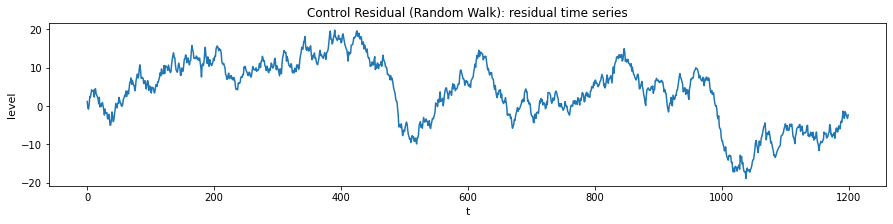

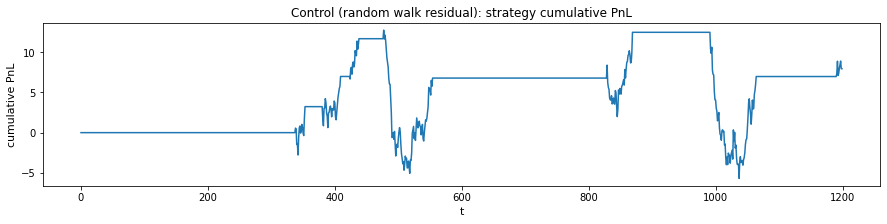

Summary:
             count   mean    std     min    25%     50%    75%    max
pnl_net 1,200.0000 0.0066 0.4966 -3.1006 0.0000 -0.0000 0.0000 3.6226


In [10]:
n = 1200
eps_rw = np.cumsum(np.random.normal(scale=1.0, size=n))  # random walk

ar1_rw, tests_rw = summarize_residual(eps_rw, name="Control Residual (Random Walk)", horizons=(1,5,20,60,120,250))

bt_rw = backtest_zscore_mean_reversion(eps_rw, lookback=200, entry=2.0, exit=0.6, cost_per_turnover=0.0015)

plt.figure()
plt.plot(bt_rw["cum_pnl"])
plt.title("Control (random walk residual): strategy cumulative PnL")
plt.xlabel("t")
plt.ylabel("cumulative PnL")
plt.show()


print("Summary:")
print(bt_rw[["pnl_net"]].describe().T)


## 9) Summary

What this notebook demonstrates:

- **Martingale baseline**: once you build a hedged residual, the default hypothesis should be “no predictability.”
  If $\varepsilon_{t+h}-\varepsilon_t$ is not forecastable from $\mathcal F_t$, there is no systematic edge in that residual.
- **OU / AR(1) is a practical language for spreads**: $\mu$ is the long-run level, $\kappa$ controls how fast the residual comes back, and the half-life tells you the relevant horizon.
- **Backtests are fragile**: even with genuine mean reversion in the data generator, poor implementation choices (wrong sign, wrong holding horizon, too much turnover, too much cost)
  can make “alpha” look like it disappeared.

A natural next step is to replace synthetic with real market data and focus on (i) residual construction/hedging, (ii) cost model realism, and (iii) out-of-sample robustness.
